In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Conv2DTranspose,concatenate,MaxPooling2D,Dropout
from tensorflow.keras.models import Model

IMG_WIDTH=448
IMG_HEIGHT=448
IMG_CHANNELS=3

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
! unzip /content/drive/MyDrive/Images

Archive:  /content/drive/MyDrive/Images.zip
   creating: train_/images/
  inflating: train_/images/CFD_002.jpg  
  inflating: train_/images/CFD_003.jpg  
  inflating: train_/images/CFD_004.jpg  
  inflating: train_/images/CFD_005.jpg  
  inflating: train_/images/CFD_006.jpg  
  inflating: train_/images/CFD_008.jpg  
  inflating: train_/images/CFD_009.jpg  
  inflating: train_/images/CFD_010.jpg  
  inflating: train_/images/CFD_012.jpg  
  inflating: train_/images/CFD_015.jpg  
  inflating: train_/images/CFD_016.jpg  
  inflating: train_/images/CFD_017.jpg  
  inflating: train_/images/CFD_018.jpg  
  inflating: train_/images/CFD_020.jpg  
  inflating: train_/images/CFD_021.jpg  
  inflating: train_/images/CFD_022.jpg  
  inflating: train_/images/CFD_023.jpg  
  inflating: train_/images/CFD_024.jpg  
  inflating: train_/images/CFD_025.jpg  
  inflating: train_/images/CFD_026.jpg  
  inflating: train_/images/CFD_027.jpg  
  inflating: train_/images/CFD_028.jpg  
  inflating: train_/images

In [4]:
import os
import numpy as np

Original=os.listdir('/content/train_/images')
Masks=os.listdir('/content/train_/masks')
print(len(Original))
print(len(Masks))

#Original=Original[0:1101]
#Masks=Masks[0:1101]

X=np.zeros((len(Original),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS), dtype=np.float32)
y=np.zeros((len(Masks),IMG_HEIGHT,IMG_WIDTH,1), dtype=np.bool)


1040
1040


<ipython-input-4-7eef16109f5c>:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y=np.zeros((len(Masks),IMG_HEIGHT,IMG_WIDTH,1), dtype=np.bool)


In [5]:

import cv2

for file in Original:
    n=Original.index(file)
    path1=os.path.join('train_/images',file)
    img=cv2.imread(path1,1)
    try:
        X[n]=img/255
        file2=Masks[n]
        path2=os.path.join('train_/masks',file2)
        mask=cv2.imread(path2,1)
        mask=cv2.cvtColor(mask,cv2.COLOR_RGB2GRAY)
        mask=np.expand_dims(mask,axis=2)
        y[n]=mask/255
    except Exception as e:
        print(e)
        print(path1)

In [6]:
from sklearn import model_selection
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.15,random_state=42)

In [7]:
inputs=tf.keras.layers.Input((448,448,3))


s = inputs

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.2)(c1)  # Original 0.1
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)


c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.2)(c2)  # Original 0.1
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)


c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

#Expansive path

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.2)(c8)  # Original 0.1
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.2)(c9)  # Original 0.1
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)




outputs = Conv2D(1,(1, 1),activation='sigmoid')(c9)

model = Model(inputs=[inputs], outputs=[outputs])

#NOTE: Compile the model in the main program to make it easy to test with various loss functions
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

####################################################################
# Model Checkpoint
checkpoint=tf.keras.callbacks.ModelCheckpoint('key_model.h5',verbose=1,save_best_only=True)
callbacks=[tf.keras.callbacks.EarlyStopping(patience=2,monitor='val_loss'),
           tf.keras.callbacks.TensorBoard(log_dir='logs')]



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 448, 448, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 448, 448, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [8]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
28/28 [==============================] - 86s 2s/step - loss: 0.2909 - accuracy: 0.8989 - val_loss: 0.2020 - val_accuracy: 0.9539
Epoch 2/10
28/28 [==============================] - 31s 1s/step - loss: 0.1863 - accuracy: 0.9549 - val_loss: 0.1808 - val_accuracy: 0.9539
Epoch 3/10
28/28 [==============================] - 32s 1s/step - loss: 0.1784 - accuracy: 0.9549 - val_loss: 0.1730 - val_accuracy: 0.9540
Epoch 4/10
28/28 [==============================] - 31s 1s/step - loss: 0.1683 - accuracy: 0.9550 - val_loss: 0.1662 - val_accuracy: 0.9546
Epoch 5/10
28/28 [==============================] - 32s 1s/step - loss: 0.1592 - accuracy: 0.9561 - val_loss: 0.1605 - val_accuracy: 0.9565
Epoch 6/10
28/28 [==============================] - 31s 1s/step - loss: 0.1370 - accuracy: 0.9584 - val_loss: 0.1488 - val_accuracy: 0.9604
Epoch 7/10
28/28 [==============================] - 31s 1s/step - loss: 0.1256 - accuracy: 0.9611 - val_loss: 0.1380 - val_accuracy: 0.9612
Epoch 8/10
28/28 [==

In [13]:
img1 = cv2.imread('img1')
img1.shape
img1 = cv2.resize(img1,(448,448))

1/1 [==============================] - 0s 31ms/step


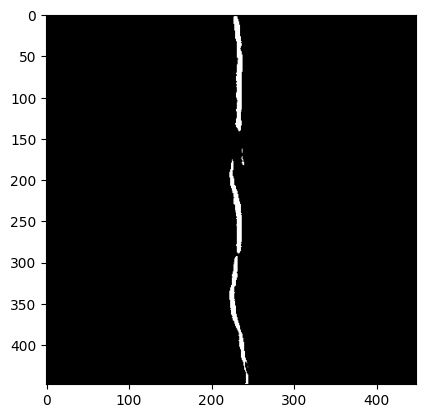

In [15]:
import numpy as np
import matplotlib.pyplot as plt
img=np.expand_dims(img1,axis=0)
pred=model.predict(img)
pred.shape
pred_0=cv2.resize(pred[0],(448,448))
plt.imshow(pred_0,cmap='gray')